In [129]:
import pandas as pd
import numpy as np
import re

from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import RandomOverSampler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

from scipy.stats import pearsonr

from matplotlib import pyplot as plt
import seaborn as sns

In [130]:
# Import the datasets

HCP = pd.read_csv("new_Data/record_1_DK.csv", index_col=0)

ROIs = pd.read_csv("new_Data/dka_HCP_test.csv")
ROIs = ROIs["name"]
columns = [ROI + "_" + str(j/2) for ROI in ROIs for j in range(0, 300)]

CamCAN = pd.read_csv('new_Data/PSD_Rest.csv', header=None)
CamCAN.columns = columns

# Drop columns 150 Hz pour HCP
col_to_drop = [c for c in HCP.columns if float(re.search("[0-9]+\.[0-9]*", c).group(0)) == 150.0]
HCP = HCP.drop(columns = col_to_drop)

In [131]:
HCP.head()

,bankssts L_0.0,bankssts L_0.5,bankssts L_1.0,bankssts L_1.5,bankssts L_2.0,bankssts L_2.5,bankssts L_3.0,bankssts L_3.5,bankssts L_4.0,bankssts L_4.5,...,transversetemporal R_145.0,transversetemporal R_145.5,transversetemporal R_146.0,transversetemporal R_146.5,transversetemporal R_147.0,transversetemporal R_147.5,transversetemporal R_148.0,transversetemporal R_148.5,transversetemporal R_149.0,transversetemporal R_149.5
Subject_ID,,,,,,,,,,,,,,,,,,,,,
100307,0.012527,0.098085,0.091595,0.062784,0.041201,0.032813,0.027429,0.026777,0.027289,0.026809,...,0.001032,0.001035,0.001030,0.001116,0.001130,0.001062,0.000993,0.001100,0.001118,0.001149
102816,0.162313,1.046752,0.273002,0.075042,0.034293,0.027701,0.038973,0.052679,0.037281,0.058347,...,0.001615,0.001585,0.001584,0.001654,0.001657,0.001675,0.001666,0.001671,0.001561,0.001507
105923,0.008516,0.065119,0.069025,0.049595,0.038891,0.035171,0.029716,0.027860,0.028589,0.028132,...,0.001147,0.001116,0.001122,0.001113,0.001153,0.001140,0.001171,0.001186,0.001192,0.001131
106521,0.014950,0.095386,0.090106,0.053828,0.039113,0.029947,0.026072,0.023446,0.023146,0.022486,...,0.001684,0.001509,0.001481,0.001573,0.001603,0.001671,0.001693,0.001654,0.001650,0.001752
108323,0.013310,0.092061,0.088514,0.056523,0.039264,0.030251,0.026005,0.025178,0.024698,0.022905,...,0.001363,0.001377,0.001384,0.001400,0.001374,0.001461,0.001417,0.001364,0.001264,0.001325


In [132]:
CamCAN.head()

,bankssts L_0.0,bankssts L_0.5,bankssts L_1.0,bankssts L_1.5,bankssts L_2.0,bankssts L_2.5,bankssts L_3.0,bankssts L_3.5,bankssts L_4.0,bankssts L_4.5,...,transversetemporal R_145.0,transversetemporal R_145.5,transversetemporal R_146.0,transversetemporal R_146.5,transversetemporal R_147.0,transversetemporal R_147.5,transversetemporal R_148.0,transversetemporal R_148.5,transversetemporal R_149.0,transversetemporal R_149.5
0,1.166112,7.310916,5.172159,2.908277,1.780837,1.194868,1.090405,1.041240,0.966275,0.866052,...,0.013225,0.014056,0.012924,0.011307,0.011478,0.011786,0.010631,0.009448,0.006987,0.003150
1,1.726824,11.262225,8.457395,5.106392,3.424434,2.753602,2.462952,2.272813,2.133286,1.975146,...,0.019069,0.017784,0.018208,0.019443,0.018315,0.017127,0.016271,0.015401,0.010584,0.007986
2,1.283245,8.512901,5.622469,3.662541,2.693076,2.195658,1.881473,1.665905,1.550854,1.544194,...,0.011910,0.012364,0.012478,0.012050,0.011816,0.012486,0.011117,0.009719,0.007808,0.003464
3,0.779096,5.631812,4.190357,2.781331,2.186175,2.060094,1.706472,1.454541,1.415902,1.377155,...,0.007378,0.007126,0.007329,0.007236,0.006535,0.006806,0.006740,0.006133,0.004261,0.002017
4,0.843786,5.370334,4.005501,2.143103,1.772349,1.449305,1.291349,1.441181,1.354650,1.279961,...,0.005973,0.006015,0.006312,0.005653,0.005771,0.005979,0.005880,0.005315,0.003970,0.001791


In [133]:
HCP

,bankssts L_0.0,bankssts L_0.5,bankssts L_1.0,bankssts L_1.5,bankssts L_2.0,bankssts L_2.5,bankssts L_3.0,bankssts L_3.5,bankssts L_4.0,bankssts L_4.5,...,transversetemporal R_145.0,transversetemporal R_145.5,transversetemporal R_146.0,transversetemporal R_146.5,transversetemporal R_147.0,transversetemporal R_147.5,transversetemporal R_148.0,transversetemporal R_148.5,transversetemporal R_149.0,transversetemporal R_149.5
Subject_ID,,,,,,,,,,,,,,,,,,,,,
100307,0.012527,0.098085,0.091595,0.062784,0.041201,0.032813,0.027429,0.026777,0.027289,0.026809,...,0.001032,0.001035,0.001030,0.001116,0.001130,0.001062,0.000993,0.001100,0.001118,0.001149
102816,0.162313,1.046752,0.273002,0.075042,0.034293,0.027701,0.038973,0.052679,0.037281,0.058347,...,0.001615,0.001585,0.001584,0.001654,0.001657,0.001675,0.001666,0.001671,0.001561,0.001507
105923,0.008516,0.065119,0.069025,0.049595,0.038891,0.035171,0.029716,0.027860,0.028589,0.028132,...,0.001147,0.001116,0.001122,0.001113,0.001153,0.001140,0.001171,0.001186,0.001192,0.001131
106521,0.014950,0.095386,0.090106,0.053828,0.039113,0.029947,0.026072,0.023446,0.023146,0.022486,...,0.001684,0.001509,0.001481,0.001573,0.001603,0.001671,0.001693,0.001654,0.001650,0.001752
108323,0.013310,0.092061,0.088514,0.056523,0.039264,0.030251,0.026005,0.025178,0.024698,0.022905,...,0.001363,0.001377,0.001384,0.001400,0.001374,0.001461,0.001417,0.001364,0.001264,0.001325
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
891667,0.011630,0.075654,0.082455,0.082037,0.071873,0.059937,0.056277,0.051145,0.049611,0.045867,...,0.001289,0.001220,0.001336,0.001369,0.001292,0.001301,0.001250,0.001351,0.001387,0.001302
898176,0.016197,0.111086,0.086742,0.054898,0.036717,0.027397,0.023868,0.024478,0.023127,0.021851,...,0.002059,0.001849,0.001890,0.002002,0.001913,0.001981,0.001819,0.001775,0.001989,0.001989
912447,0.010285,0.065490,0.073507,0.060437,0.045459,0.037802,0.034007,0.034731,0.034975,0.036081,...,0.001204,0.001216,0.001211,0.001290,0.001229,0.001242,0.001179,0.001109,0.001104,0.001196


In [134]:
CamCAN

,bankssts L_0.0,bankssts L_0.5,bankssts L_1.0,bankssts L_1.5,bankssts L_2.0,bankssts L_2.5,bankssts L_3.0,bankssts L_3.5,bankssts L_4.0,bankssts L_4.5,...,transversetemporal R_145.0,transversetemporal R_145.5,transversetemporal R_146.0,transversetemporal R_146.5,transversetemporal R_147.0,transversetemporal R_147.5,transversetemporal R_148.0,transversetemporal R_148.5,transversetemporal R_149.0,transversetemporal R_149.5
0,1.166112,7.310916,5.172159,2.908277,1.780837,1.194868,1.090405,1.041240,0.966275,0.866052,...,0.013225,0.014056,0.012924,0.011307,0.011478,0.011786,0.010631,0.009448,0.006987,0.003150
1,1.726824,11.262225,8.457395,5.106392,3.424434,2.753602,2.462952,2.272813,2.133286,1.975146,...,0.019069,0.017784,0.018208,0.019443,0.018315,0.017127,0.016271,0.015401,0.010584,0.007986
2,1.283245,8.512901,5.622469,3.662541,2.693076,2.195658,1.881473,1.665905,1.550854,1.544194,...,0.011910,0.012364,0.012478,0.012050,0.011816,0.012486,0.011117,0.009719,0.007808,0.003464
3,0.779096,5.631812,4.190357,2.781331,2.186175,2.060094,1.706472,1.454541,1.415902,1.377155,...,0.007378,0.007126,0.007329,0.007236,0.006535,0.006806,0.006740,0.006133,0.004261,0.002017
4,0.843786,5.370334,4.005501,2.143103,1.772349,1.449305,1.291349,1.441181,1.354650,1.279961,...,0.005973,0.006015,0.006312,0.005653,0.005771,0.005979,0.005880,0.005315,0.003970,0.001791
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
601,0.490361,3.243846,2.155718,1.250172,0.863927,0.677191,0.590376,0.509947,0.449933,0.473210,...,0.011788,0.012969,0.013162,0.012005,0.011087,0.011011,0.011528,0.010376,0.008227,0.003675
602,0.511913,3.502638,2.023911,1.184041,0.878807,0.703701,0.630240,0.589358,0.616874,0.585480,...,0.008249,0.007720,0.007367,0.007467,0.007591,0.007411,0.007099,0.006436,0.004233,0.001874
603,0.419833,2.815661,1.672338,0.984622,0.768490,0.672284,0.588229,0.489535,0.474703,0.485580,...,0.010485,0.011226,0.011397,0.010561,0.010135,0.010105,0.009239,0.008512,0.006104,0.002701
604,0.667436,4.144461,2.650255,1.496356,1.137125,1.147805,1.004732,0.917386,0.894860,0.852936,...,0.015055,0.015974,0.015488,0.014894,0.014855,0.013612,0.012033,0.011293,0.009625,0.008268


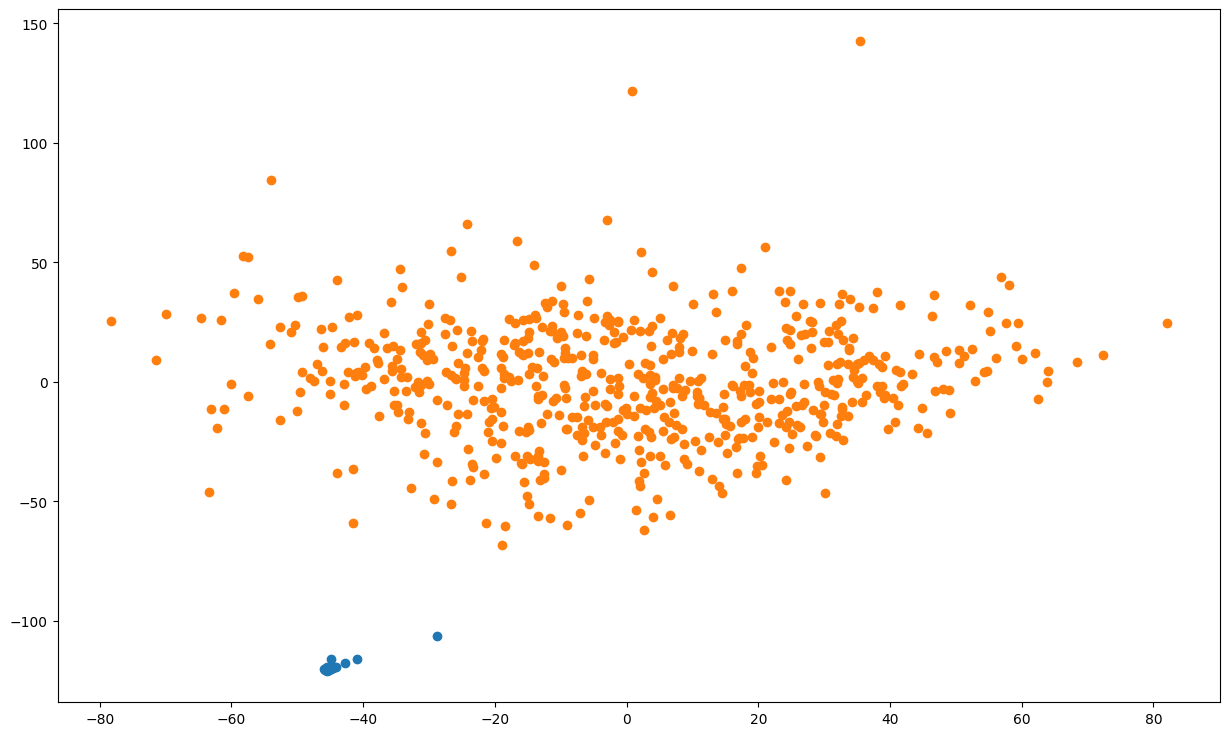

In [135]:
pca = PCA(n_components=2)

pca.fit(CamCAN)

HCP_PCA = pca.transform(HCP)
CamCAN_PCA = pca.transform(CamCAN)

plt.figure(figsize=(15, 9))
plt.scatter(HCP_PCA[:, 0], HCP_PCA[:, 1])
plt.scatter(CamCAN_PCA[:, 0], CamCAN_PCA[:, 1])

plt.show()

In [136]:
### Let's remove site effect

# 1. Regress site effect

data = np.concatenate([CamCAN, HCP], axis = 0)
site = np.concatenate([np.zeros(len(CamCAN)), np.ones(len(HCP))]).reshape(-1, 1)
data = np.concatenate([data, site], axis = 1)

X = data[:,-1:].astype(np.int64)
y = data[:, :-1]

ros = RandomOverSampler(random_state=0)
y_resampled, X_resampled = ros.fit_resample(y, X)
X_resampled = X_resampled.reshape(-1, 1)

model = LinearRegression()

model.fit(X_resampled, y_resampled)

LinearRegression()

In [137]:
model.predict([[1]])

array([[0.0161569 , 0.11589149, 0.08845089, ..., 0.00138923, 0.00137665,
        0.00138228]])

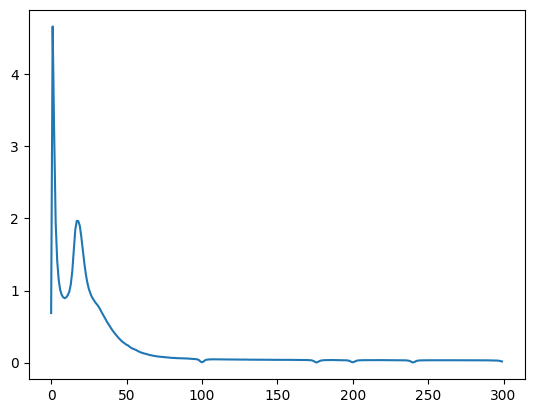

In [138]:
plt.plot(model.predict([[0]])[0, :300])

In [139]:
model.intercept_

array([0.6875228 , 4.66278446, 3.1917189 , ..., 0.01082368, 0.00848576,
       0.00548862])

In [140]:
model.coef_

array([[-6.71365905e-01],
       [-4.54689296e+00],
       [-3.10326801e+00],
       ...,
       [-9.43444922e-03],
       [-7.10910519e-03],
       [-4.10633748e-03]])

In [141]:
np.concatenate([model.intercept_.reshape(1, -1)]*len(CamCAN), axis=0)

array([[0.6875228 , 4.66278446, 3.1917189 , ..., 0.01082368, 0.00848576,
        0.00548862],
       [0.6875228 , 4.66278446, 3.1917189 , ..., 0.01082368, 0.00848576,
        0.00548862],
       [0.6875228 , 4.66278446, 3.1917189 , ..., 0.01082368, 0.00848576,
        0.00548862],
       ...,
       [0.6875228 , 4.66278446, 3.1917189 , ..., 0.01082368, 0.00848576,
        0.00548862],
       [0.6875228 , 4.66278446, 3.1917189 , ..., 0.01082368, 0.00848576,
        0.00548862],
       [0.6875228 , 4.66278446, 3.1917189 , ..., 0.01082368, 0.00848576,
        0.00548862]])

In [142]:
# 2. Remove site effect

CamCAN_regressed = CamCAN - model.predict([[0]]) + np.concatenate([model.intercept_.reshape(1, -1)]*len(CamCAN), axis=0)
HCP_regressed = HCP - model.predict([[1]]) + np.concatenate([model.intercept_.reshape(1, -1)]*len(HCP), axis=0)

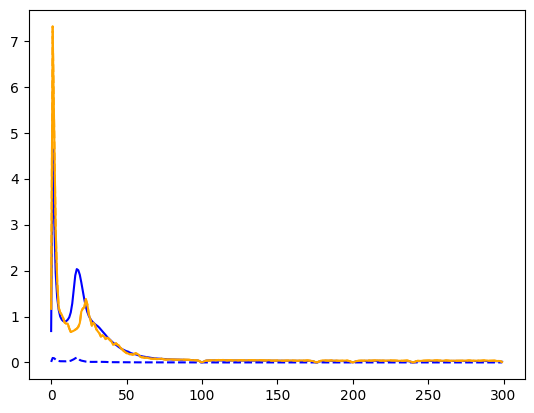

In [143]:
plt.plot(HCP_regressed.to_numpy()[0, :300], color = "blue", linestyle = "-")
plt.plot(HCP.to_numpy()[0, :300], color = "blue", linestyle = "--")

plt.plot(CamCAN_regressed.to_numpy()[0, :300], color = "orange", linestyle = "-")
plt.plot(CamCAN.to_numpy()[0, :300], color = "orange", linestyle = "--")

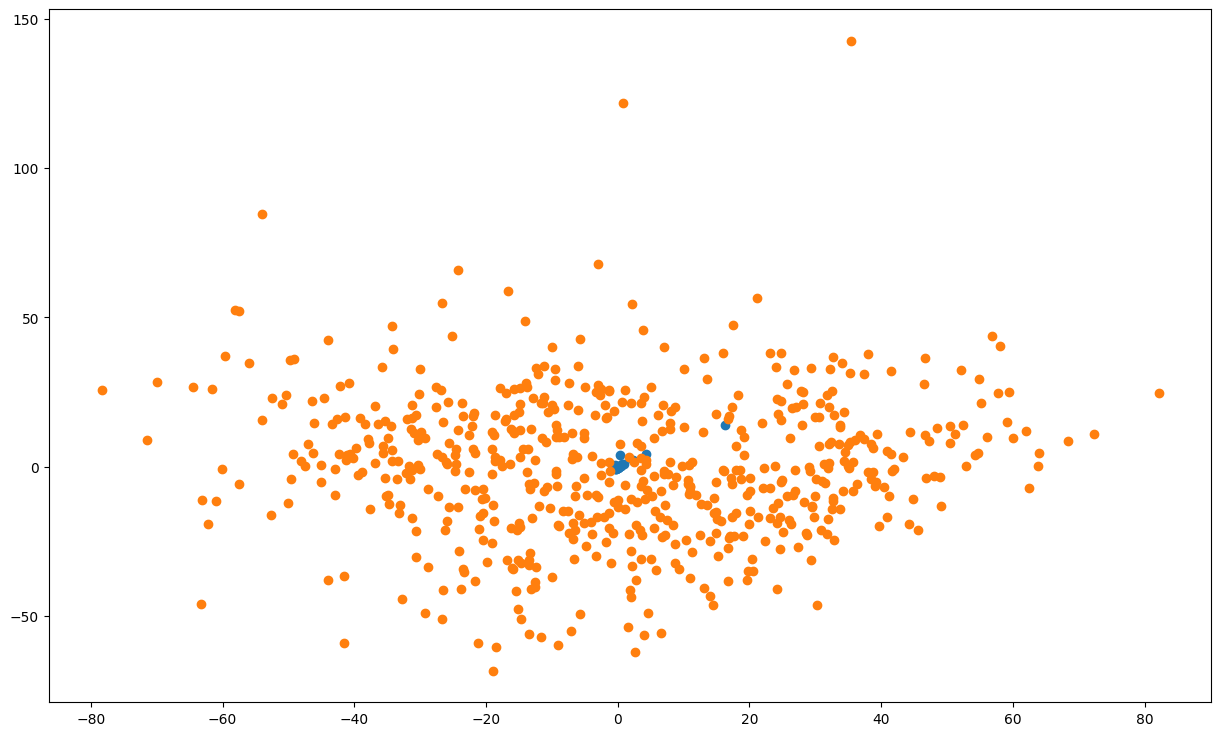

In [144]:
# Let's observe the new 2D projection

pca = PCA(n_components=2)

pca.fit(CamCAN_regressed)

HCP_PCA = pca.transform(HCP_regressed)
CamCAN_PCA = pca.transform(CamCAN_regressed)

plt.figure(figsize=(15, 9))
plt.scatter(HCP_PCA[:, 0], HCP_PCA[:, 1])
plt.scatter(CamCAN_PCA[:, 0], CamCAN_PCA[:, 1])

plt.show()

In [145]:
# Let's log the data 
HCP = np.log(HCP_regressed)
CamCAN = np.log(CamCAN_regressed)

# Let's zscore this data
scaler = StandardScaler()
HCP = scaler.fit_transform(HCP)
CamCAN = scaler.fit_transform(CamCAN)

In [160]:
# Import data for final training

demographics = pd.read_csv('new_Data/demographics_4_Guilia.csv')

# To predict
col_to_predict = "age"
y = demographics[col_to_predict]
y = y.to_numpy()

# Features
X = CamCAN.copy()

# Remove Nan Values
index = np.where(np.isnan(y) == True)[0]
X = np.delete(X, index, axis=0)
y = np.delete(y, index, axis=0)

# Remove the outliers, ex here one with a score of 0
index = np.where(y == 0)[0]
X = np.delete(X, index, axis=0)
y = np.delete(y, index, axis=0)

# Train-Test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3)

# Linear Rigde Regression
lr = Lasso(alpha=0.5)
lr.fit(X_train, y_train)

lr.score(X_train, y_train), lr.score(X_test, y_test)

(0.8626609394571783, 0.7199963532043976)

MSE training :  46.89546889112216
MSE test :  88.2461964558076
Correlation test :  PearsonRResult(statistic=0.8493059825748516, pvalue=8.001106031045928e-52)


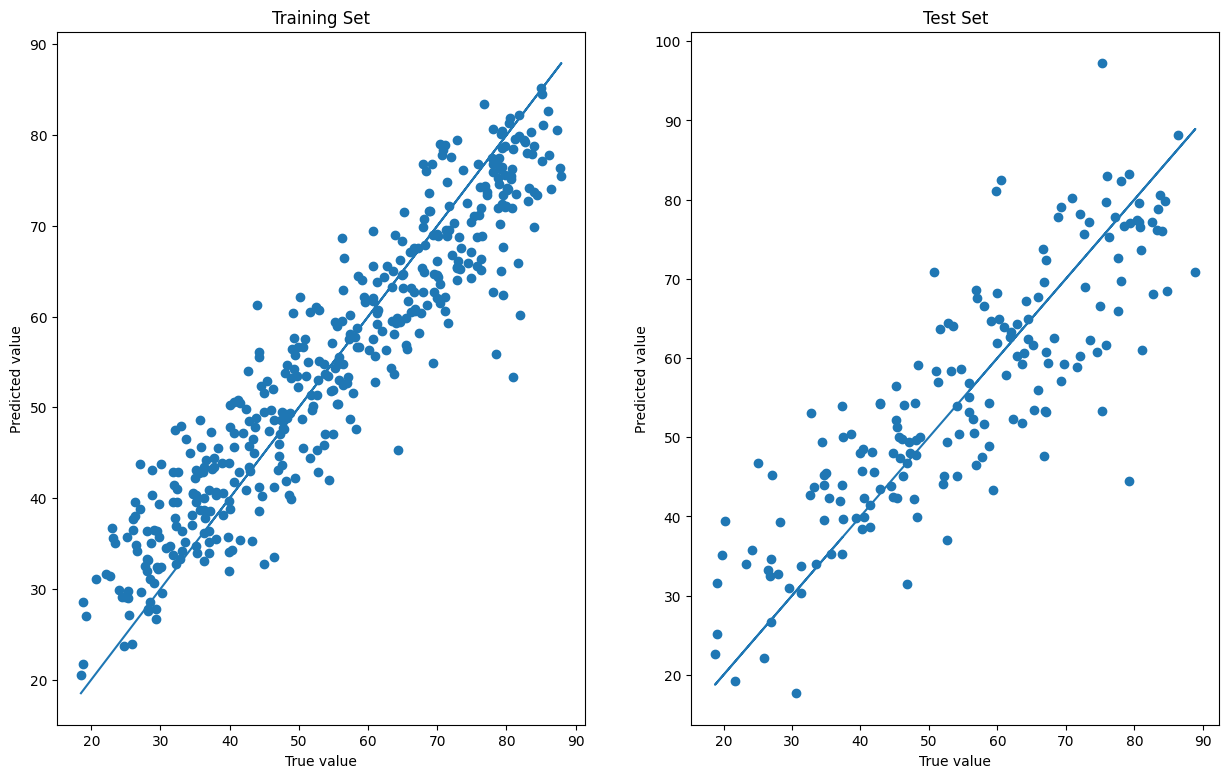

In [161]:
_, (ax0, ax1) = plt.subplots(figsize = (15, 9), ncols=2)

y_train_pred = lr.predict(X_train)
# y_train, y_train_pred = scaler_output.inverse_transform(y_train), scaler_output.inverse_transform(y_train_pred)
print("MSE training : ", mean_squared_error(y_train, y_train_pred))

ax0.scatter(x=y_train, y=y_train_pred)
ax0.plot(y_train, y_train)
ax0.set_title("Training Set")
ax0.set_xlabel("True value")
ax0.set_ylabel("Predicted value")

y_test_pred = lr.predict(X_test)
# y_test, y_test_pred = scaler_output.inverse_transform(y_test), scaler_output.inverse_transform(y_test_pred)
print("MSE test : ", mean_squared_error(y_test, y_test_pred))

ax1.scatter(x=y_test, y=y_test_pred)
ax1.plot(y_test, y_test)
ax1.set_title("Test Set")
ax1.set_xlabel("True value")
ax1.set_ylabel("Predicted value")

print("Correlation test : ", pearsonr(y_test, y_test_pred))


In [162]:
# Import data for final testing

data_HCP = pd.read_csv("new_Data/All_Data_RESTRICTED.csv", index_col=0)
HCP_df = pd.read_csv("new_Data/record_1_DK.csv", index_col=0)

data_HCP = data_HCP.loc[HCP_df.index]
age_HCP = data_HCP["Age_in_Yrs"]

MSE training :  747.7915751157336
Correlation test :  PearsonRResult(statistic=0.4004192372303966, pvalue=0.00010101418628326523)


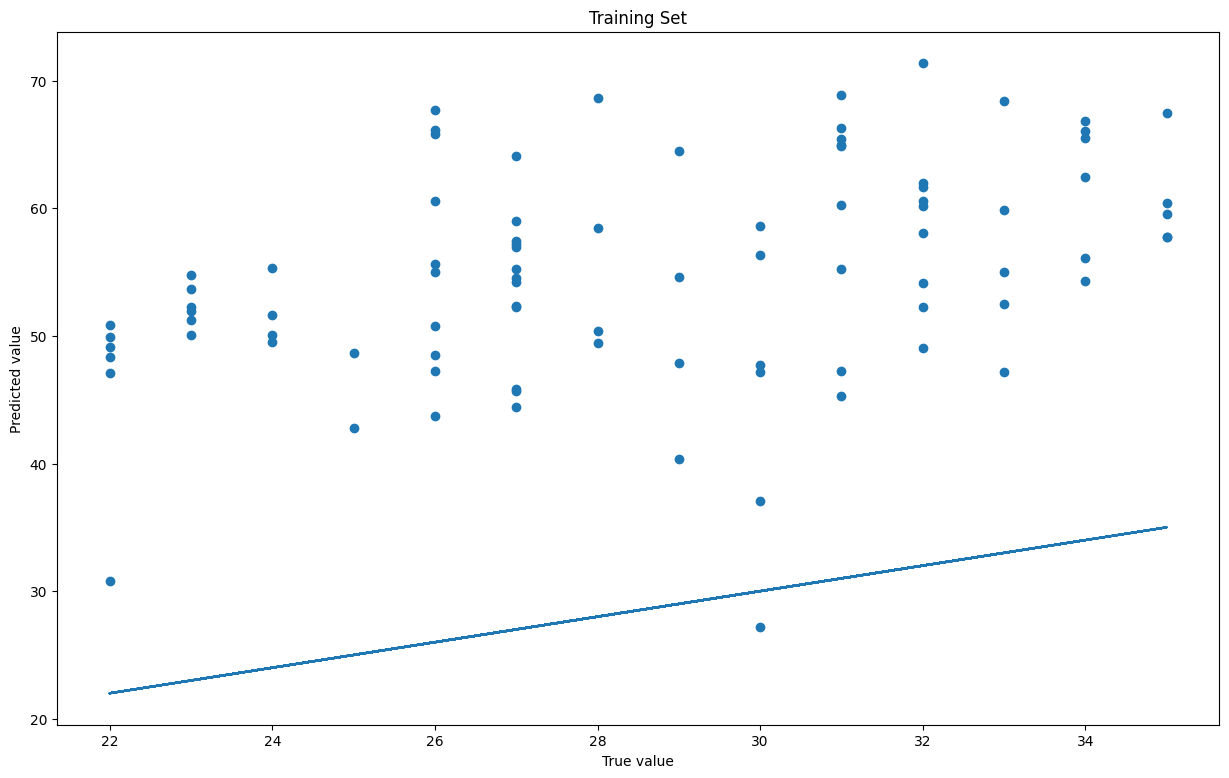

In [163]:
_, ax0 = plt.subplots(figsize = (15, 9), ncols=1)

pred = lr.predict(HCP)
true_value = age_HCP

# y_train, y_train_pred = scaler_output.inverse_transform(y_train), scaler_output.inverse_transform(y_train_pred)
print("MSE training : ", mean_squared_error(pred, true_value))

ax0.scatter(x=true_value, y=pred)
ax0.plot(true_value, true_value)
ax0.set_title("Training Set")
ax0.set_xlabel("True value")
ax0.set_ylabel("Predicted value")

print("Correlation test : ", pearsonr(true_value, pred))


In [169]:
np.mean(age_HCP), lr.intercept_, np.mean(y)

(28.60674157303371, 54.8550660148748, 54.69)

MSE training :  58.8170391115934
Correlation test :  PearsonRResult(statistic=0.4004192372303966, pvalue=0.00010101418628326523)


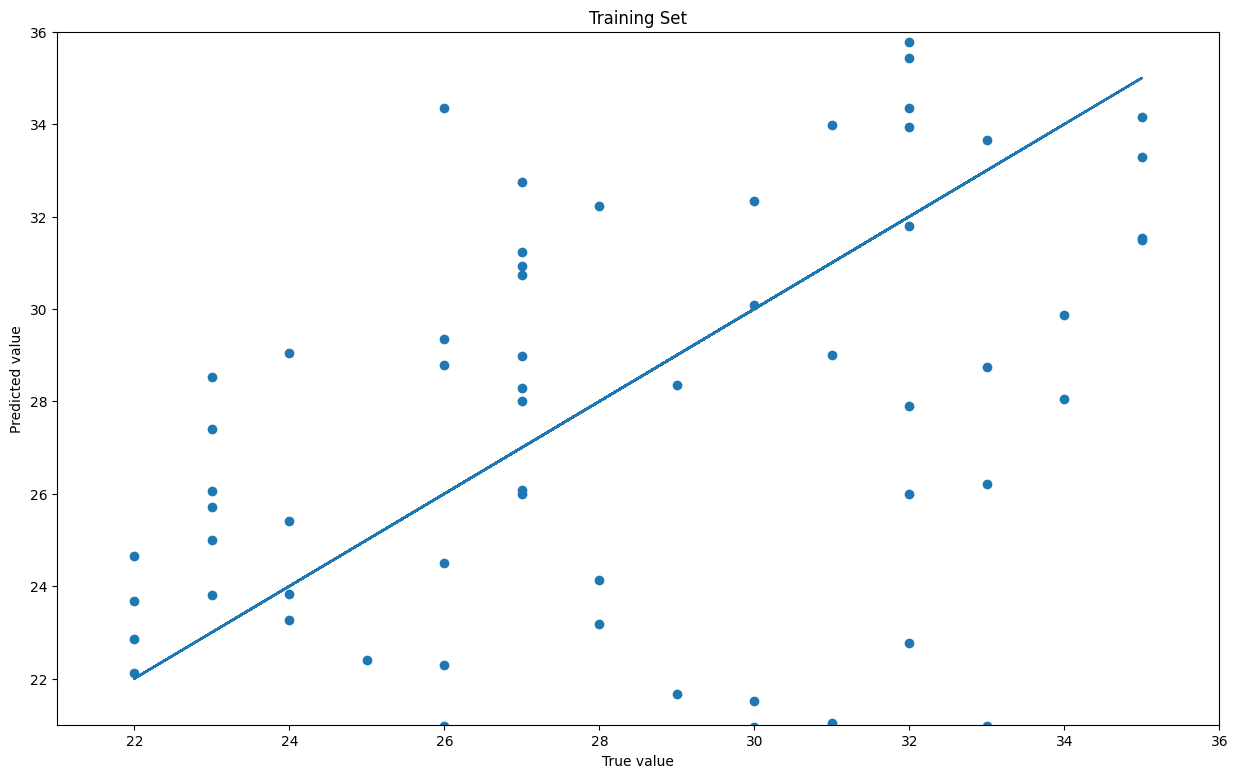

In [173]:
# This time we are going to correct the intercept which is biased because of old people from the CamCAN

mean_age_HCP = np.mean(age_HCP)
mean_age_prediction_model = lr.intercept_

_, ax0 = plt.subplots(figsize = (15, 9), ncols=1)

pred = lr.predict(HCP)
pred = pred - mean_age_prediction_model + mean_age_HCP
true_value = age_HCP

# y_train, y_train_pred = scaler_output.inverse_transform(y_train), scaler_output.inverse_transform(y_train_pred)
print("MSE training : ", mean_squared_error(pred, true_value))

ax0.scatter(x=true_value, y=pred)
ax0.plot(true_value, true_value)
ax0.set_title("Training Set")
ax0.set_xlabel("True value")
ax0.set_ylabel("Predicted value")

ax0.set_xlim(xmin = min(true_value)-1, xmax = max(true_value)+1 )
ax0.set_ylim(ymin = min(true_value)-1, ymax = max(true_value)+1 )

print("Correlation test : ", pearsonr(true_value, pred))


In [ ]:
# Remove mean age before fitting 
# pmat24
# Gene expression over expressed and underexpressed 